In this file, we build a neural network for sign language interpretation. 
<p>Data from [here](http://empslocal.ex.ac.uk/people/staff/np331/index.php?section=FingerSpellingDataset)

### Setup

In [1]:
# Get the list of all files in this directory
from os.path import join, exists
from os import listdir, getcwd, mkdir
PATH = join(getcwd(), 'ds9')
import glob
files = [file for file in glob.glob(PATH + '/**/*.png', recursive=True)]
#print(len(files), files[:10])

Seems like the recursive method worked. Next, some helper methods to visualize individual images.

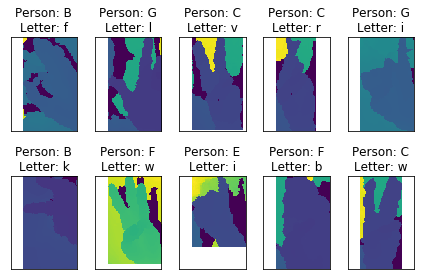

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

def opencvfile(path):
    # Read the file using OpenCV
    pic = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    return pic

def plot_opencvfile(path, ax=None):
    # Plot the file on provided axis (if applicable)
    if ax is None:
        ax = plt.gca()
    ax.imshow(opencvfile(path))
    
def plot_ten_images(filepaths, seed=1):
    # Plot a 2x5 grid of random images
    np.random.seed(seed)
    indices = np.random.randint(low=0, high=len(filepaths), size=10)
    fig, axes = plt.subplots(2, 5, sharex=True, sharey=True)
    for i in range(10):
        axis = axes.flatten()[i]
        plot_opencvfile(filepaths[indices[i]], axis)
        
        title = filename_to_title(filepaths[indices[i]])
        axis.set_title(title)
        axis.set_xticks([])
        axis.set_yticks([])
    plt.gcf().tight_layout()
    
def get_person_letter_from_path(path):
    # Use the file path to infer which person is giving the signal, and which letter it actually is
    return(path[path.index('ds9')+4:path.rfind('.')].split('\\')[:2])

def filename_to_title(path):
    # Turn the filename into a title noting the person and the letter
    person, letter = get_person_letter_from_path(path)
    title = 'Person: {0:s}\nLetter: {1:s}'.format(person, letter)                                                            
    #print(title)
    return(title)

# Test
plot_ten_images(files)

Depth images are colored by distance to the source. That's okay--you can still make out where the hand and fingers are in each case (though you may not be able to distinguish individual fingers from each other).
<p>Next, we should create the test set. As the link above points out, we should pick one user to be the test set. We'll pick user A--even though they have the fewest examples, they still have over 100 per letter on average. That's more than enough for testing, and for training purposes we need as much data as possible.

In [3]:
def get_images_for_user(user):
    # Get all images for a given user
    PATH = join('C:/', 'Users', 'Muneeb Alam', 'Desktop', 'McKinsey', 'Learning', 'Programming', 
                     'Python', 'Deep learning', 'Signs', 'ds9', user)
    files = [file for file in glob.glob(PATH + '/**/*.png', recursive=True)]
    return(files)
for user in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']:
    print(user, len(get_images_for_user(user)))

A 3592
B 11431
C 7749
D 7101
E 5958
F 9784
G 10503
H 11526
I 5032


In [4]:
# Dict of file: (user, letter)
files_letters = {file: get_person_letter_from_path(file) for file in files}

# Separate into lists of images and letter labels, training and test
training_images = []
training_letters = []
test_images = []
test_letters = []
for file, (user, letter) in files_letters.items():
    if user == 'A':
        test_images.append(file)
        test_letters.append(letter)
    else:
        training_images.append(file)
        training_letters.append(letter)
print(len(training_images), len(test_images))

69084 3592


Now that we have the files, we should turn them into usable formats. They're already 2D arrays of ints, so we should scale to 0-1 and zero-pad them to the same size. We also need to downsample because if we try to load everything after padding and scaling only, our computer will run out of memory. (And remember--this is the *smaller* ASL signs dataset.) 

In [5]:
def get_shape(path):
    return opencvfile(path).shape

def get_max_rows(imagefiles):
    return max([img.shape[0] for img in imagefiles])

def get_max_cols(imagefiles):
    return max([img.shape[1] for img in imagefiles])

def zero_pad_image(image, maxr, maxc):
    # Create a new array of zeros, set equal to original image from top left corner
    newarray = np.zeros((maxr, maxc))
    newarray[:image.shape[0], :image.shape[1]] = image
    return newarray

from skimage.measure import block_reduce

def downsample_image(img, tosize=(32, 32)):
    # Uses mean to get image to tosize dimensions; zero-pads if too small
    if len(img.shape) != len(tosize):
        print('Need to provide target size with same number of dimensions as image')
        return img
    dims = list(img.shape)
    for d, dim in enumerate(tosize):
        dims[d] = img.shape[d]//dim + 1
    img2 = block_reduce(img, block_size=tuple(dims))
    img2 = zero_pad_image(img2, tosize[0], tosize[1])
    return img2

def zero_center_whiten_image(img):
    u, o = img.mean(), img.std()
    img_z = (img - u) / o
    img_sc = img_z #(img_z - img_z.min()) / (img_z.max() - img_z.min())
    #print(img_sc.mean(), img_sc.std(), img_sc.max(), img_sc.min())
    return img_sc

In [6]:
# Code to generate numpy arrays
# OLD CODE
run_this_code = False
if False:
    for user in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']:
        # For each user, get their images
        images = get_images_for_user(user)
        imagefiles = [opencvfile(path) for path in images]

        # Get max dimensions to match later
        maxr = get_max_rows(imagefiles)
        maxc = get_max_cols(imagefiles)

        # Zero pad each image as needed
        lst = [None for i in range(len(imagefiles))]
        for i, img in enumerate(imagefiles):
            lst[i] = zero_pad_image2(img, maxr, maxc)
        imagelist = np.concatenate(lst)
        np.save(join(getcwd(), 'ds9', '{0:s}_signs.npy'.format(user)), imagelist)

        # Save labels as well
        imagelabels = '\n'.join([get_person_letter_from_path(file)[1] for file in images])
        w = open(join(getcwd(), 'ds9', '{0:s}_labels.txt'.format(user)), 'w')
        w.write(imagelabels)
        w.close()

        print('Done with', user)

# NEW CODE
if run_this_code:
    for user in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']:
        # For each user, get their images
        images = get_images_for_user(user)
        imagefiles = [opencvfile(path) for path in images]

        # Zero pad each image as needed
        lst = [None for i in range(len(imagefiles))]
        for i, img in enumerate(imagefiles):
            lst[i] = downsample_image(zero_center_whiten_image(img))
        imagelist = np.array(lst)
        np.save(join(getcwd(), 'ds9', '{0:s}_signs_32x32.npy'.format(user)), imagelist)

        # Save labels as well
        imagelabels = '\n'.join([get_person_letter_from_path(file)[1] for file in images])
        w = open(join(getcwd(), 'ds9', '{0:s}_labels_32x32.txt'.format(user)), 'w')
        w.write(imagelabels)
        w.close()

        print('Done with', user)

Now we can read everything back in and finally get started.

In [7]:
training_images = np.concatenate([np.load(join(getcwd(), 'ds9', '{0:s}_signs_32x32.npy'.format(user))) \
                                          for user in ['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']])
training_labels = []
for user in ['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']:
    reader = open(join(getcwd(), 'ds9', '{0:s}_labels_32x32.txt'.format(user)), 'r')
    training_labels += reader.read().strip().split('\n')
    reader.close()
training_labels = np.array(training_labels)
print(training_images.shape, training_labels.shape)

(69084, 32, 32) (69084,)


In [8]:
test_images = np.load(join(getcwd(), 'ds9', '{0:s}_signs_32x32.npy'.format('A')))
test_labels = []
reader = open(join(getcwd(), 'ds9', '{0:s}_labels_32x32.txt'.format('A')), 'r')
test_labels += reader.read().strip().split('\n')
reader.close()
test_labels = np.array(test_labels)
print(test_images.shape, test_labels.shape)

(3592, 32, 32) (3592,)


### SVM

Support vector machines aren't bad--a quick one can get 97% on MNIST, for example.
<p>Here, we'll create a pipeline that cross-validates and fits an SVM with data flattening for preprocessing.
<p>EDIT: We skip it because it takes so long to train.

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5], 'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}
#clf = GridSearchCV(SVC(), param_grid)
clf = SVC()
#clf.fit(training_images.reshape(training_images.shape[0], -1), 
#        training_labels)

### Basic CNN
<p>We'll construct a CNN structured as follows:
<ol>
    <li>ReLU CNN with 10 features and a 2x2 window
    <li>25% dropout
    <li>ReLU CNN with 10 features and a 2x2 window
    <li>Flatten
    <li>Dense with 64 nodes
    <li>Softmax
</ol>
<p>Additionally, we'll run with several learning rate values and compare through 50 epochs.

In [10]:
X_train = np.reshape(training_images, (training_images.shape[0], 1, training_images.shape[1], training_images.shape[2]))
from keras.utils.np_utils import to_categorical
import keras.preprocessing.text as pretext
uniqueletters = {letter: index for index, letter in enumerate(np.unique(training_labels))}
y_train = to_categorical([uniqueletters[x] for x in training_labels])
y_train

Using TensorFlow backend.


array([[ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]])

In [11]:
from keras.models import Sequential, load_model, model_from_json
from keras.layers import Dense, Dropout, Flatten, Conv2D
from keras.callbacks import EarlyStopping
from keras import optimizers

We'll also add some code to append some numbers we want to track to a pandas dataframe.

In [12]:
import pandas as pd
import pickle

def get_model_history_filename(modelname):
    folderpath = join(PATH, 'modelhist')
    if not exists(folderpath):
        mkdir(folderpath)
    filepath = join(folderpath, '{0:s}.pkl'.format(modelname))
    return filepath

def get_model_object_filename(modelname):
    folderpath = join(PATH, 'modelhist')
    if not exists(folderpath):
        mkdir(folderpath)
    filepath = join(folderpath, '{0:s} obj.h5'.format(modelname))
    return filepath

def get_model_architecture_filename(modelname):
    folderpath = join(PATH, 'modelhist')
    if not exists(folderpath):
        mkdir(folderpath)
    filepath = join(folderpath, '{0:s} arc.json'.format(modelname))
    return filepath

def save_history(modelname, modelhist):
    filepath = get_model_history_filename(modelname)
    with open(filepath, 'wb') as file_pi:
        pickle.dump(modelhist, file_pi)
        
def load_history(modelname):
    r = open(get_model_history_filename(modelname), 'rb')
    data = pickle.load(r)
    r.close()
    return data

def save_obj(modelname, model):
    filepath = get_model_object_filename(modelname)
    model.save(filepath)
    
def load_obj(modelname):
    return load_model(get_model_object_filename(modelname))
    
def save_architecture(modelname, model):
    filepath = get_model_architecture_filename(modelname)
    with open(filepath, 'w') as file:
        file.write(model.to_json())

def load_architecture(modelname):
    r = open(get_model_architecture_filename(modelname))
    data = r.read().strip()
    r.close()
    return data

def load_model_from_architecture(modelname):
    return model_from_json(load_architecture(modelname))

def save_model_attr(modelname, model, obj=True, arch=True):
    if obj:
        save_obj(modelname, model)
    if arch:
        save_architecture(modelname, model)
        
def add_to_df(current_df=None, history=None, modeltype=None):
    if current_df is None:
        current_df = pd.DataFrame()
    if history is None:
        print('Need history obj')
        return current_df
    
    trainacc = history['acc']
    valacc = history['val_acc']
    trainloss = history['loss']
    valloss = history['val_loss'] 
    for vals, trainval, valtype in zip((trainacc, valacc, trainloss, valloss),
                                      ('Train', 'Val', 'Train', 'Val'),
                                      ('Acc', 'Acc', 'Loss', 'Loss')):
        if vals is not None:
            tempdf = pd.DataFrame({'Value': vals}).assign(TrainVal=trainval, Type=valtype, ModelType = modeltype)
            tempdf.loc[:, 'epoch'] = tempdf.index + 1
            current_df = current_df.append(tempdf)
    return current_df

compdf = None

In [13]:
np.random.seed(8)
random_indices = np.random.randint(low=0, high=len(y_train), size=10000)
X_train2 = X_train[random_indices]
y_train2 = y_train[random_indices]

model = Sequential()
model.add(Conv2D(10, (2, 2), activation='relu', input_shape=X_train.shape[1:], data_format='channels_first'))
model.add(Dropout(0.25))
model.add(Conv2D(10, (2, 2), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(len(uniqueletters), activation='softmax'))
save_architecture("Simple CNN", model)

In [14]:
for lr in range(-4, 0):
    learning_rate = 10**lr
    modelname = r'Simple CNN, LR=$10^{0:d}$'.format(lr)
    if not exists(get_model_history_filename(modelname)):
        np.random.seed(8)

        model = load_model_from_architecture('Simple CNN')
        opt_adam = optimizers.Adam(lr=learning_rate)
        model.compile(optimizer=opt_adam, loss='categorical_crossentropy', metrics=['accuracy'])

        history = model.fit(X_train2, y_train2, validation_split=0.3, epochs=10, callbacks=[EarlyStopping(patience=3)],
                           verbose=0)
        save_history(modelname, history.history)
        save_model_attr(modelname, model)
        print('Done fitting simple CNN with lr 10^{0:d}'.format(lr))
    history = load_history(modelname)
    compdf = add_to_df(compdf, history, modelname)

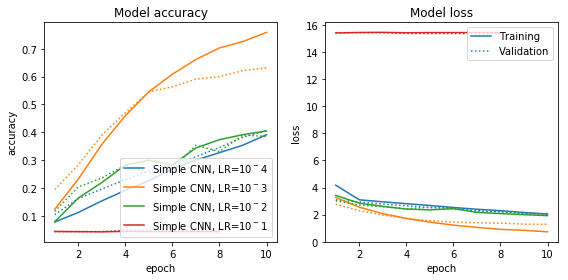

In [15]:
def plot_comparison(df):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=[8, 4])
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    for i, modeltype in enumerate(df.ModelType.unique()):
        tempdf = df[df.ModelType == modeltype]
        
        accdf = tempdf[tempdf.Type == "Acc"]
        accdf1 = accdf[accdf.TrainVal == "Train"]
        accdf2 = accdf[accdf.TrainVal == "Val"]
        ax1.plot(accdf1.epoch, accdf1.Value, color=colors[i], ls='-', label=modeltype)
        ax1.plot(accdf2.epoch, accdf2.Value, color=colors[i], ls=':', label='_nolegend_')
        
        lossdf = tempdf[tempdf.Type == "Loss"]
        lossdf1 = lossdf[accdf.TrainVal == "Train"]
        lossdf2 = lossdf[accdf.TrainVal == "Val"]
        if i == 0:
            ax2.plot(lossdf1.epoch, lossdf1.Value, color=colors[i], ls='-', label='Training')
            ax2.plot(lossdf2.epoch, lossdf2.Value, color=colors[i], ls=':', label='Validation')
        else:
            ax2.plot(lossdf1.epoch, lossdf1.Value, color=colors[i], ls='-', label='_nolegend_')
            ax2.plot(lossdf2.epoch, lossdf2.Value, color=colors[i], ls=':', label='_nolegend_')
    
    # accuracy
    ax1.set_title('Model accuracy')
    ax1.set_ylabel('accuracy')
    ax1.set_xlabel('epoch')
    ax1.legend(loc='lower right')

    # loss
    ax2.set_title('Model loss')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.legend(loc='upper right')
    
    fig.tight_layout()
    
plot_comparison(compdf)

Two takeaways here:
<ul><li>It looks like the best learning rate is $10^{-3}$. We'll move forward with that. 
<li>We're overfitting as well. We'll assume the training accuracy is ok temporarily and instead focus on reducing the variance via dropout. 
</ul>

In [16]:
lr = -3
learning_rate = 10**lr
modelname = 'Dropout CNN'
if not exists(get_model_history_filename(modelname)):
    np.random.seed(8)

    model = Sequential()
    model.add(Conv2D(10, (2, 2), activation='relu', input_shape=X_train.shape[1:], data_format='channels_first'))
    model.add(Dropout(0.25))
    model.add(Conv2D(10, (2, 2), activation='relu'))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(len(uniqueletters), activation='softmax'))

    opt_adam = optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=opt_adam, loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train2, y_train2, validation_split=0.3, epochs=20, callbacks=[EarlyStopping(patience=3)])
    save_history(modelname, history.history)
    save_model_attr(modelname, model)
    print('Done fitting dropout CNN with lr 10^{0:d}'.format(lr))
history = load_history(modelname)

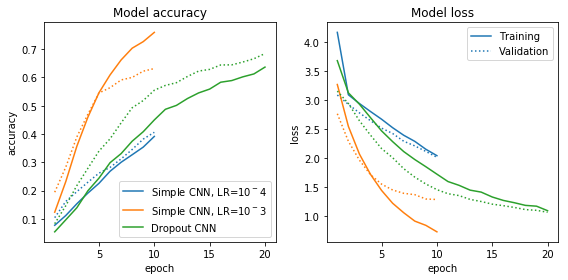

In [17]:
# Keep only 10^-4 and 10^3 versions
compdf2 = compdf[(compdf.ModelType == 'Simple CNN, LR=$10^{0:d}$'.format(-4)) | \
                 (compdf.ModelType == 'Simple CNN, LR=$10^{0:d}$'.format(-3))]

compdf2 = add_to_df(compdf2, history, modelname)

plot_comparison(compdf2)

This was more aggressive than it needed to be. We'll remove one dropout layer and add in batch normalization between each convolutional or dense layer and activation.

In [18]:
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation

In [19]:
modelname = 'Batch Norm CNN'
if not exists(get_model_history_filename(modelname)):
    np.random.seed(8)

    model = Sequential()
    model.add(Conv2D(10, (2, 2), kernel_initializer='uniform', input_shape=X_train.shape[1:], data_format='channels_first'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(Conv2D(10, (2, 2), kernel_initializer='uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(64, kernel_initializer='uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(len(uniqueletters), activation='softmax'))

    model.compile(optimizer=opt_adam, loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train2, y_train2, validation_split=0.3, epochs=20, callbacks=[EarlyStopping(patience=3)])
    save_history(modelname, history.history)
    save_model_attr(modelname, model)
    print('Done fitting batch norm CNN with lr 10^{0:d}'.format(lr))
history = load_history(modelname)

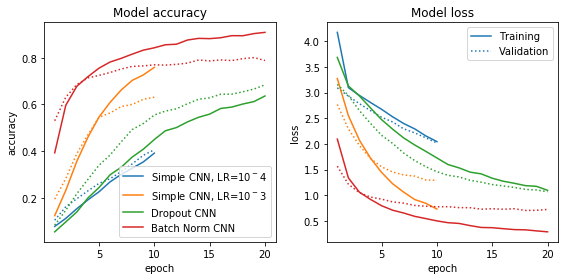

In [20]:
compdf3 = compdf2

compdf3 = add_to_df(compdf3, history, modelname)

plot_comparison(compdf3)

This is much better. Let's re-introduce the dropout layer we removed last time.

In [21]:
modelname = 'Batch Drop CNN'
if not exists(get_model_history_filename(modelname)):
    np.random.seed(8)

    model = Sequential()
    model.add(Conv2D(10, (2, 2), kernel_initializer='uniform', input_shape=X_train.shape[1:], data_format='channels_first'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(Conv2D(10, (2, 2), kernel_initializer='uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(64, kernel_initializer='uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(Dense(len(uniqueletters), activation='softmax'))

    model.compile(optimizer=opt_adam, loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train2, y_train2, validation_split=0.3, epochs=20, callbacks=[EarlyStopping(patience=3)])
    save_history(modelname, history.history)
    save_model_attr(modelname, model)
    print('Done fitting batch norm dropout CNN with lr 10^{0:d}'.format(lr))
history = load_history(modelname)

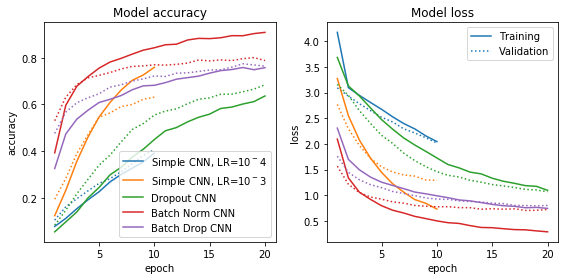

In [22]:
compdf4 = compdf3

compdf4 = add_to_df(compdf4, history, modelname)

plot_comparison(compdf4)

Now let's focus again on the bias. We need to improve the accuracy from ~75%--we can try a few different things:
<ul>
    <li>Deeper network
    <li>More training steps
    <li>Better optimization algorithm
    <li>Better architecture
    <li>More thorough hyperparameter search
</ul>
<p>First, let's try a [few other optimizers](https://keras.io/optimizers/): SGD, Adadelta, and Nadam. 

In [23]:
opt_sgd = optimizers.SGD(lr=learning_rate)
opt_adad = optimizers.Adadelta() #documentation says default values recommended
opt_nadam = optimizers.Nadam() #documentation says default values recommended

In [24]:
compdf5 = compdf4[(compdf4.ModelType == 'Batch Norm CNN') | (compdf4.ModelType == 'Batch Drop CNN')]

for opt, optname in zip((opt_sgd, opt_adad, opt_nadam), ('SGD', 'Adadelta', 'Nadam')):
    modelname = '{0:s} CNN'.format(optname)
    if not exists(get_model_history_filename(modelname)):
        np.random.seed(8)

        model = load_model_from_architecture('Batch Drop CNN')

        model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

        history = model.fit(X_train2, y_train2, validation_split=0.3, epochs=20, callbacks=[EarlyStopping(patience=3)],
                           verbose=0)
        save_history(modelname, history.history)
        save_model_attr(modelname, model)
        print('Done fitting with {0:s}'.format(optname))
        
    history = load_history(modelname)
    compdf5 = add_to_df(compdf5, history, modelname)

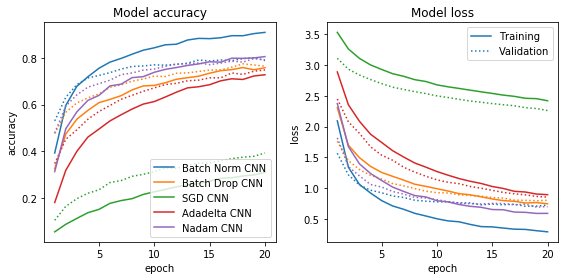

In [25]:
plot_comparison(compdf5)

We'll switch to Nadam--looks like there could be a slight improvement.
<p>Next, let's try a couple of max pooling layers.

In [26]:
from keras.layers import MaxPooling2D

In [27]:
modelname = 'Nadam Pool'.format(optname)
if not exists(get_model_history_filename(modelname)):
    np.random.seed(8)

    model = Sequential()
    model.add(Conv2D(10, (2, 2), kernel_initializer='uniform', input_shape=X_train.shape[1:], data_format='channels_first'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.25))
    model.add(Conv2D(10, (2, 2), kernel_initializer='uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(64, kernel_initializer='uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(Dense(len(uniqueletters), activation='softmax'))

    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train2, y_train2, validation_split=0.3, epochs=20, callbacks=[EarlyStopping(patience=3)])
    save_history(modelname, history.history)
    save_model_attr(modelname, model)
    print('Done fitting with {0:s}'.format(optname))
    
history = load_history(modelname)
compdf6 = add_to_df(compdf5, history, modelname)

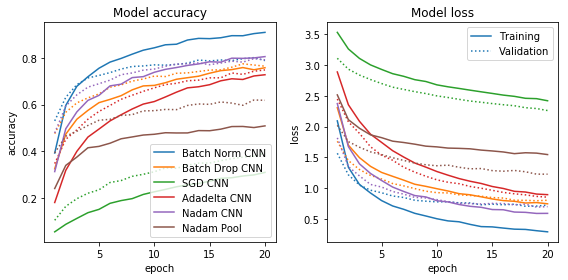

In [28]:
plot_comparison(compdf6)

Let's also add a callback that reduces the learning rate when training plateaus. We'll also increase the patience to 10.

In [29]:
from keras.callbacks import ReduceLROnPlateau

In [30]:
modelname = 'NP LR'.format(optname)
if not exists(get_model_history_filename(modelname)):
    np.random.seed(8)

    model = load_model_from_architecture('Nadam Pool')

    model.compile(optimizer=opt_nadam, loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train2, y_train2, validation_split=0.3, epochs=20, 
                        callbacks=[EarlyStopping(patience=10),
                                  ReduceLROnPlateau(factor=0.8, patience=3)])
    save_history(modelname, history.history)
    save_model_attr(modelname, model)
    print('Done fitting with {0:s}'.format(optname))
    
history = load_history(modelname)
compdf7 = add_to_df(compdf6, history, modelname)

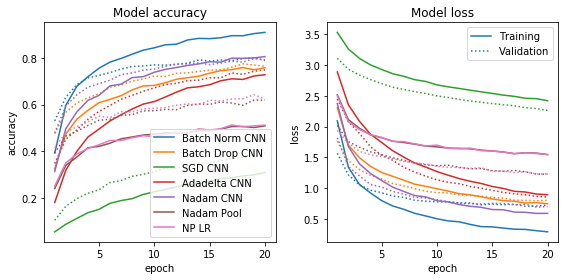

In [31]:
plot_comparison(compdf7)

That didn't seem to be effective.
<p>Last thing to try before training on full data: more nodes and more layers.

In [32]:
modelname = 'Nadam exp'
if not exists(get_model_history_filename(modelname)):
    np.random.seed(8)

    model = Sequential()
    model.add(Conv2D(20, (2, 2), kernel_initializer='uniform', input_shape=X_train.shape[1:], data_format='channels_first'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(Conv2D(20, (2, 2), kernel_initializer='uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(Conv2D(20, (2, 2), kernel_initializer='uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, kernel_initializer='uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(Dense(len(uniqueletters), activation='softmax'))

    model.compile(optimizer=opt_nadam, loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train2, y_train2, validation_split=0.3, epochs=20, callbacks=[EarlyStopping(patience=3)],
                       verbose=1)
    save_history(modelname, history.history)
    save_model_attr(modelname, model)
    print('Done fitting with {0:s}'.format(optname))

history = load_history(modelname)

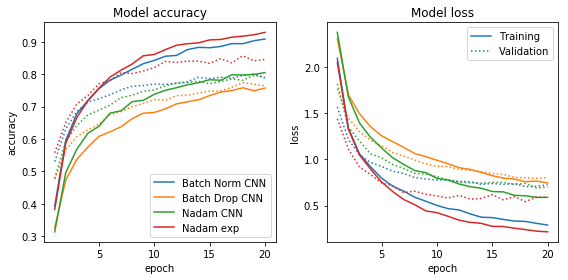

In [33]:
compdf8 = compdf7[(compdf7.ModelType == "Batch Norm CNN") | \
                 (compdf7.ModelType == "Batch Drop CNN") | \
                 (compdf7.ModelType == "Nadam CNN")]
compdf8 = add_to_df(compdf8, history, modelname)
plot_comparison(compdf8)

Now let's run on full data.

In [34]:
modelname = 'Nadam full'
if not exists(get_model_history_filename(modelname)):
    np.random.seed(8)

    model = load_model_from_architecture('Nadam exp')
    model.compile(optimizer=opt_nadam, loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train, y_train, validation_split=0.3, epochs=100, callbacks=[EarlyStopping(patience=3)],
                       verbose=1)
    save_history(modelname, history.history)
    save_model_attr(modelname, model)
    print('Done fitting with {0:s}'.format(optname))

history = load_history(modelname)

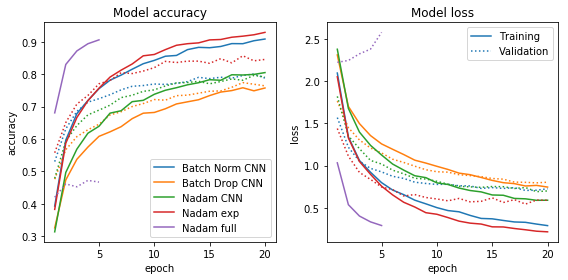

In [35]:
compdf9 = compdf8
compdf9 = add_to_df(compdf9, history, modelname)
plot_comparison(compdf9)

That's...not what we were going for. Maybe one of the issues is that not enough of the dropout layers really got to "learn" because there were so few training steps. 
<p>Let's reintroduce max pooling and use a higher patience.

In [36]:
modelname = 'Nadam plus'
if not exists(get_model_history_filename(modelname)):
    np.random.seed(8)

    model = Sequential()
    model.add(Conv2D(20, (2, 2), kernel_initializer='uniform', input_shape=X_train.shape[1:], data_format='channels_first'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.25))
    model.add(Conv2D(20, (2, 2), kernel_initializer='uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.25))
    model.add(Conv2D(20, (2, 2), kernel_initializer='uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(128, kernel_initializer='uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(Dense(len(uniqueletters), activation='softmax'))

    model.compile(optimizer=opt_nadam, loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train, y_train, validation_split=0.3, epochs=100, callbacks=[EarlyStopping(patience=10)],
                       verbose=1)
    save_history(modelname, history.history)
    save_model_attr(modelname, model)
    print('Done fitting with {0:s}'.format(optname))

history = load_history(modelname)

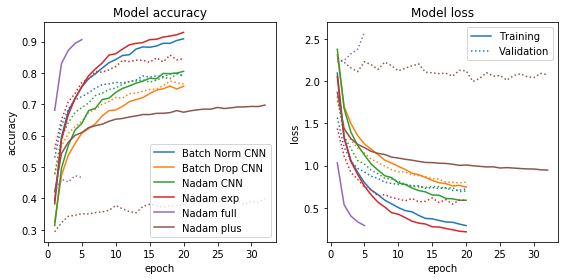

In [37]:
compdf10 = compdf9
compdf10 = add_to_df(compdf10, history, modelname)
plot_comparison(compdf10)

This fit was really poor. Let's prototype a deeper network and remove dropout in the convolutional layers.

In [38]:
modelname = 'Nadam deep'
if not exists(get_model_history_filename(modelname)):
    np.random.seed(8)

    model = Sequential()
    model.add(Conv2D(20, (2, 2), kernel_initializer='uniform', input_shape=X_train.shape[1:], data_format='channels_first'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(20, (2, 2), kernel_initializer='uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(20, (2, 2), kernel_initializer='uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(20, (2, 2), kernel_initializer='uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(20, (2, 2), kernel_initializer='uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(128, kernel_initializer='uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(Dense(len(uniqueletters), activation='softmax'))

    model.compile(optimizer=opt_nadam, loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train2, y_train2, validation_split=0.3, epochs=100, callbacks=[EarlyStopping(patience=10)],
                       verbose=1)
    save_history(modelname, history.history)
    save_model_attr(modelname, model)
    print('Done fitting with {0:s}'.format(optname))

history = load_history(modelname)

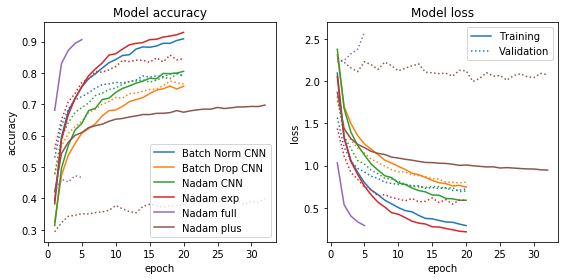

In [39]:
compdf11 = compdf9
compdf11 = add_to_df(compdf11, history, modelname)
plot_comparison(compdf10)

Still no good.
<p>Let's revisit the "Nadam full" model. Why was the performance so much worse with more data? Is there a vanishing gradient? Is the learning rate too low?
<p>First, let's look at how the accuracy changes with the amount of data.

In [40]:
for proportion in np.arange(0.2, 1.1, 0.2):
    np.random.seed(8)
    random_indices = np.random.randint(low=0, high=len(y_train), size=int(len(y_train)*proportion))
    X_train_temp = X_train[random_indices]
    y_train_temp = y_train[random_indices]
    modelname = 'Nadam {0:.0f}%'.format(proportion * 100)
    if not exists(get_model_history_filename(modelname)):
        np.random.seed(8)

        model = load_model_from_architecture('Nadam full') 
        model.compile(optimizer=opt_nadam, loss='categorical_crossentropy', metrics=['accuracy'])

        history = model.fit(X_train_temp, y_train_temp, validation_split=0.3, epochs=10, 
                            callbacks=[EarlyStopping(patience=3)], verbose=1)
        save_history(modelname, history.history)
        print('Done fitting with {0:s}'.format(optname))

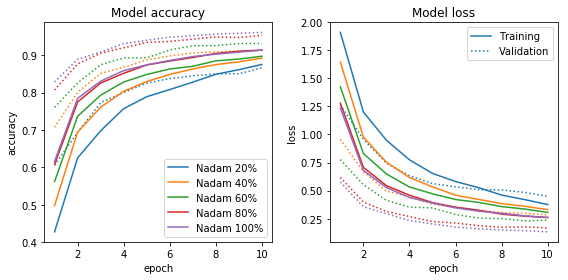

In [41]:
propdf = None
for proportion in np.arange(0.2, 1.1, 0.2):
    modelname = 'Nadam {0:.0f}%'.format(proportion * 100)
    propdf = add_to_df(propdf, load_history(modelname), modelname)
plot_comparison(propdf)

This is curious. When we used the full data, above, we got poor results. But here, when we sample with replacement N times from the N-observation-long training data, we get our most accurate model yet--closing in on 98% accuracy on the validation set if we run to ~40 epochs.

In [42]:
for proportion in np.arange(0.2, 1.1, 0.2):
    np.random.seed(8)
    random_indices = np.random.choice(len(y_train), size=int(len(y_train)*proportion), replace=False)
    X_train_temp = X_train[random_indices]
    y_train_temp = y_train[random_indices]
    modelname = 'Nadam {0:.0f}% wor'.format(proportion * 100)
    if not exists(get_model_history_filename(modelname)):
        np.random.seed(8)

        model = load_model_from_architecture('Nadam full') 
        model.compile(optimizer=opt_nadam, loss='categorical_crossentropy', metrics=['accuracy'])

        history = model.fit(X_train_temp, y_train_temp, validation_split=0.3, epochs=10, 
                            callbacks=[EarlyStopping(patience=3)], verbose=1)
        save_history(modelname, history.history)
        save_model_attr(modelname, model)
        print('Done fitting with {0:s}'.format(optname))

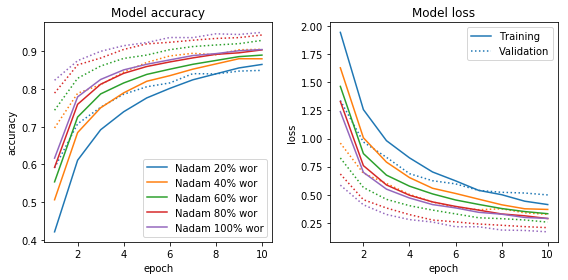

In [43]:
propdf = None
for proportion in np.arange(0.2, 1.1, 0.2):
    modelname = 'Nadam {0:.0f}% wor'.format(proportion * 100)
    propdf = add_to_df(propdf, load_history(modelname), modelname)
plot_comparison(propdf)

So maybe the issue was a wacky data ordering issue. We got caught in a saddle point or vanishing gradient trap or something above, but after getting the data in a random order, everything seems ok.
<p>To verify, let me run with the original order, and then reshuffle and run again a couple of times.

In [44]:
for i in range(3):
    modelname = 'Nadam shuffle-{0:d}x'.format(i)
    if not exists(get_model_history_filename(modelname)):
        neworder = list(range(len(y_train)))
        for j in range(i):
            np.random.seed(8)
            np.random.shuffle(neworder)
            
        X_train_temp = X_train[neworder]
        y_train_temp = y_train[neworder]

        np.random.seed(8)

        model = load_model_from_architecture('Nadam full') 
        model.compile(optimizer=opt_nadam, loss='categorical_crossentropy', metrics=['accuracy'])

        history = model.fit(X_train_temp, y_train_temp, validation_split=0.3, epochs=10, callbacks=[EarlyStopping(patience=3)],
                           verbose=1)
        save_history(modelname, history.history)
        save_model_attr(modelname, model)
        print('Done fitting with {0:s}'.format(optname))

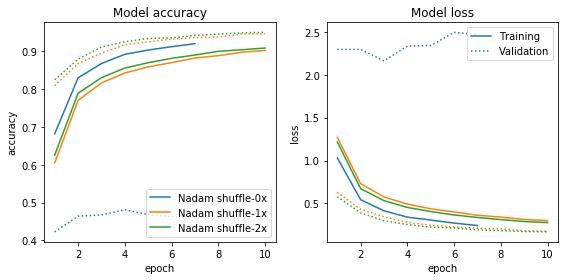

In [45]:
shuffledf = None
for i in range(3):
    modelname = 'Nadam shuffle-{0:d}x'.format(i)
    shuffledf = add_to_df(shuffledf, load_history(modelname), modelname)
plot_comparison(shuffledf)

Yes, seems like it was a quirk of the original ordering. The original ordering is in groups--some of one letter, followed by some of another. We should have randomized to begin with.
<p>We can look at specific examples the model got incorrect and start to examine why using [lime](https://github.com/marcotcr/lime) and [influence functions](https://github.com/kohpangwei/influence-release).

In [46]:
### TODO